In [1]:
import pandas as pd
import ast
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors

import torch
from torchinfo import summary
import torchvision
import torcheval


import math
import random
from collections import Counter

sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Работа с исходными данными

## Обработка метаданных

Загрузим метаданные о датасете и данные о диагнозах

In [2]:
meta_df = pd.read_csv('ptbxl_database.csv', index_col=0)
scp_df = pd.read_csv('scp_statements.csv')

meta_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,"{'ISCAS': 50.0, 'SR': 0.0}",MID,NaN,NaN,1.0,True,True,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


Отфильтруем данные.

В метаданных нужно оставить столбцы, включающие в себя диагноз, путь к файлу с временным рядом, разделения на 10 групп. Обработаем столбец с заключениями в соответствии с синтаксисом словаря.

В данных о диагнозах оставим только диагностические заключения

In [3]:
meta_df.scp_codes = meta_df.scp_codes.apply(lambda x: ast.literal_eval(x))
meta_df = meta_df[['scp_codes', 'strat_fold', 'filename_lr']]


scp_df = scp_df[scp_df.diagnostic == 1]
diagnose_set = set(scp_df['Unnamed: 0'])

meta_df

,scp_codes,strat_fold,filename_lr
ecg_id,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,records100/00000/00001_lr
2,"{'NORM': 80.0, 'SBRAD': 0.0}",2,records100/00000/00002_lr
3,"{'NORM': 100.0, 'SR': 0.0}",5,records100/00000/00003_lr
4,"{'NORM': 100.0, 'SR': 0.0}",3,records100/00000/00004_lr
5,"{'NORM': 100.0, 'SR': 0.0}",4,records100/00000/00005_lr
...,...,...,...
21833,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",7,records100/21000/21833_lr
21834,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",4,records100/21000/21834_lr
21835,"{'ISCAS': 50.0, 'SR': 0.0}",2,records100/21000/21835_lr


## Загрузка временных рядов

Для дальнейшего анализа будем использовать записи с частотой 100 измерений в секунду. Загрузим записи в numpy массив

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = ''
sampling_rate=100

X = load_raw_data(meta_df, sampling_rate, path)
X = X.transpose(0,2,1)
X.shape

(21837, 12, 1000)

Размер полученных данных соответствует 21837 случаям, для каждого проведено 12 одновременных измерений по 10*100=1000 точек

Визуализируем одно из ЭКГ

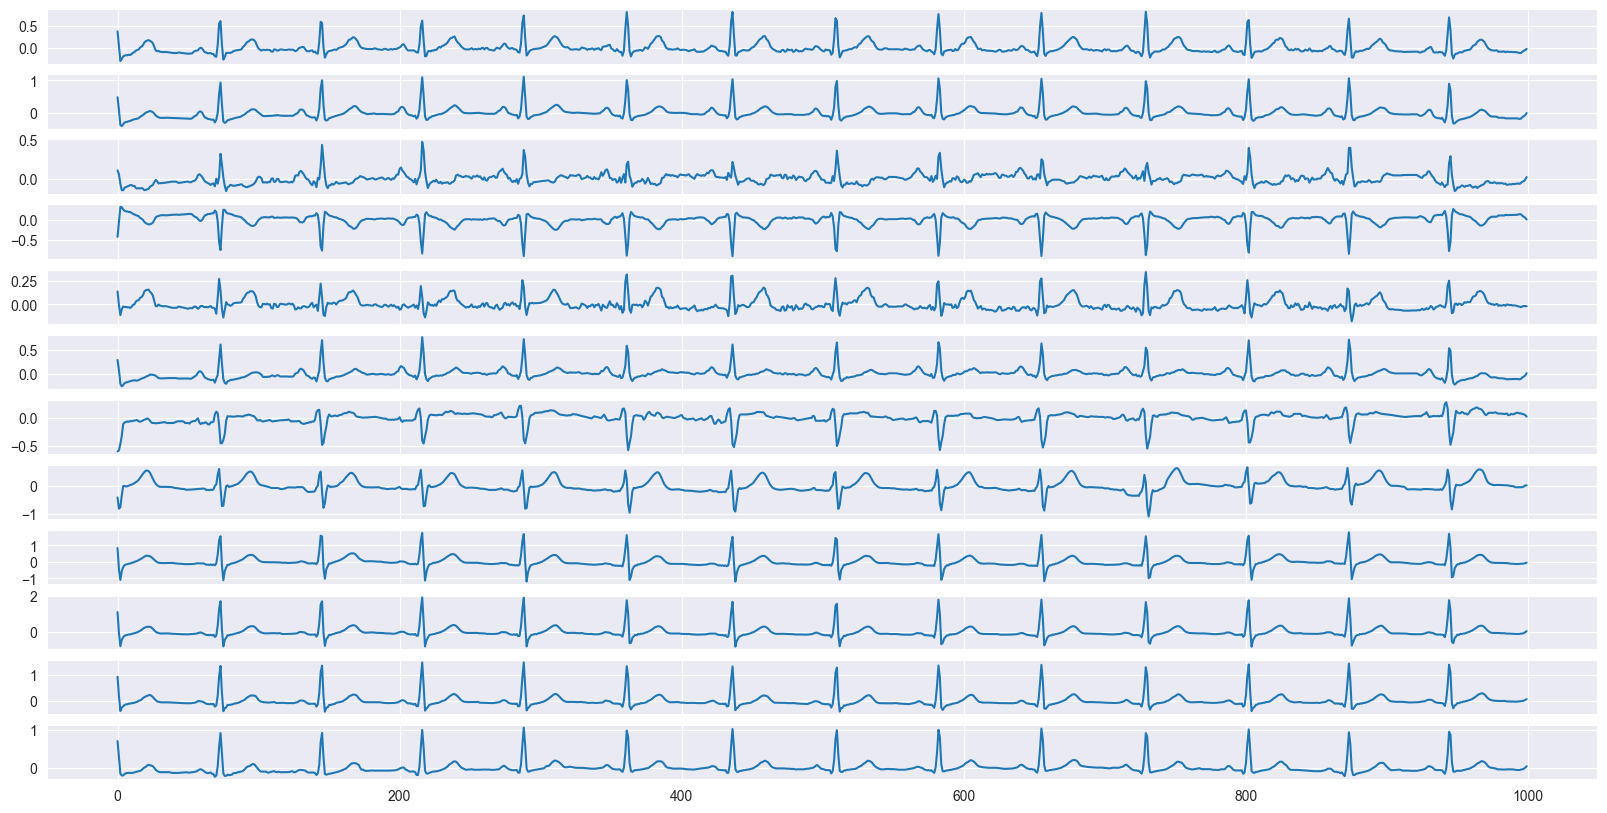

In [5]:
sample = X[45]

fig, axes = plt.subplots(12, 1, figsize=(20,10), sharex=True)
for i in range(12):
    sns.lineplot(x=np.arange(sample.shape[1]), y=sample[i, :], ax=axes[i])
plt.show()

## Разметка данных

Разметим ЭКГ, будем использовать только диагностические заметки, уровень будет равен степени уверенности в диагнозе

In [6]:
def marking(labels, classes):
    # Словарь для индексов классов
    classes_dict = {key: value for key, value in zip(classes, range(len(classes)))}
    res = np.zeros([len(labels), len(classes)])
    # Пройдёмся по каждому диагнозу, в нём просматриваем словарь, проверяем входит ли запись в диагнозы и, если да, то записываем значение в пределах [0,1]
    for i, ecg in enumerate(labels):
        for key, value in ecg.items():
            if key in classes_dict:
                j = classes_dict[key]
                res[i,j] = value/100
    return res    
    

In [7]:
Y = marking(meta_df.scp_codes, diagnose_set)

In [8]:
test_fold = [10]

X_test = []
Y_test = []
X_train = []
Y_train = []

for i in range(len(meta_df)):
    if Y[i].sum() == 0:
        continue
    if meta_df.iloc[i]['strat_fold'] in test_fold:
        X_test.append(X[i])
        Y_test.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])
    print(f"Done {i} of {len(meta_df)}", end='\r')

X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

## Анализ данных

#### Определение функций

In [9]:
def num_classes_row(data, name):
    count = np.zeros(len(diagnose_set))
    for row in data:
        num = (row > 0).sum()
        count[num] += 1
    plt.figure(figsize=(20, 6))
    plt.bar(np.arange(len(diagnose_set)), count)
    plt.title(f"Распределение количества диагнозов по ЭКГ в {name} датасете")
    plt.show()
    print({num: cnt for num, cnt in zip(range(len(count)), count)})


def num_classes_dataset(data, name):
    count = (data > 0).sum(axis=0)
    plt.figure(figsize=(20, 6))
    plt.bar(list(diagnose_set), count)
    plt.xticks(rotation=60)
    plt.title(f"Распределение частоты диагнозов в {name} датасете")
    plt.show()

def sum_coef_classes_dataset(data, name):
    count = data.sum(axis=0)
    plt.figure(figsize=(20, 6))
    plt.bar(list(diagnose_set), count)
    plt.xticks(rotation=60)
    plt.title(f"Распределение диагнозов, учитывая стпень уверенности в {name} датасете")
    plt.show()


def avg_coef_classes_dataset(data, name):
    count1 = data.sum(axis=0)
    count2 = (data > 0).sum(axis=0)
    avg_count = count1 / count2
    plt.figure(figsize=(20, 6))
    plt.bar(list(diagnose_set), avg_count)
    plt.xticks(rotation=60)
    plt.title(f"Распределение средней уверенности в диагнозе в {name} датасете")
    plt.show()
    

#### Анализ обучающего и тестового датасетов

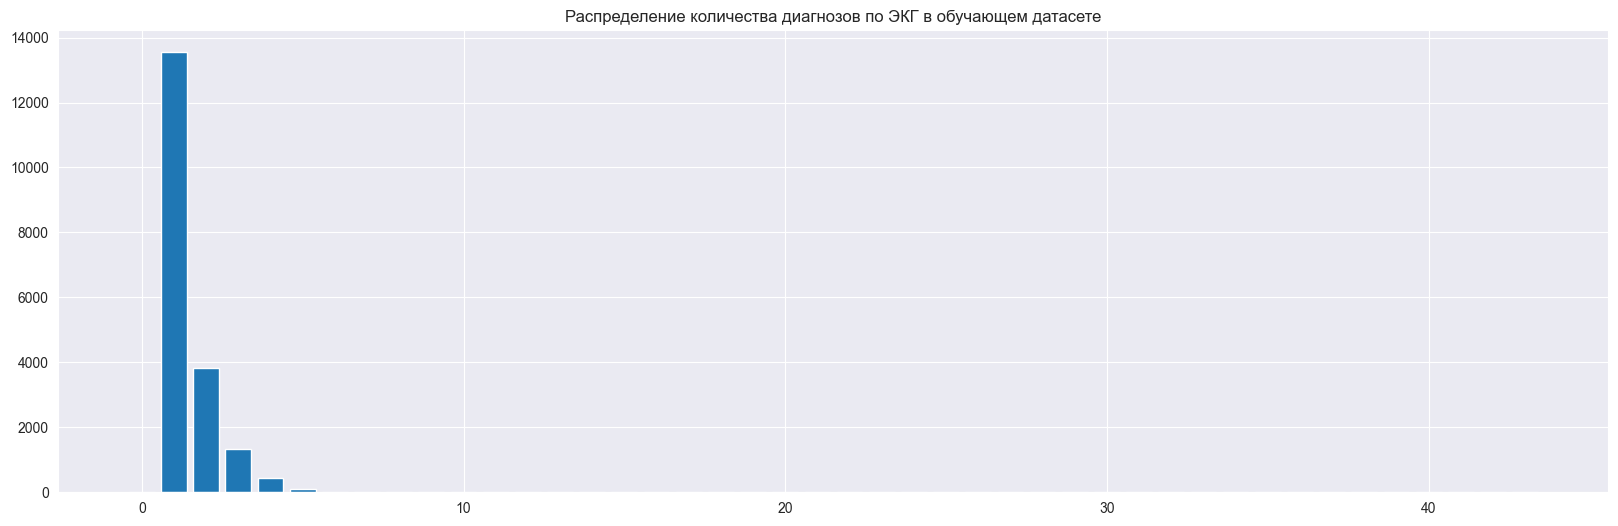

{0: 0.0, 1: 13547.0, 2: 3817.0, 3: 1333.0, 4: 454.0, 5: 104.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0}


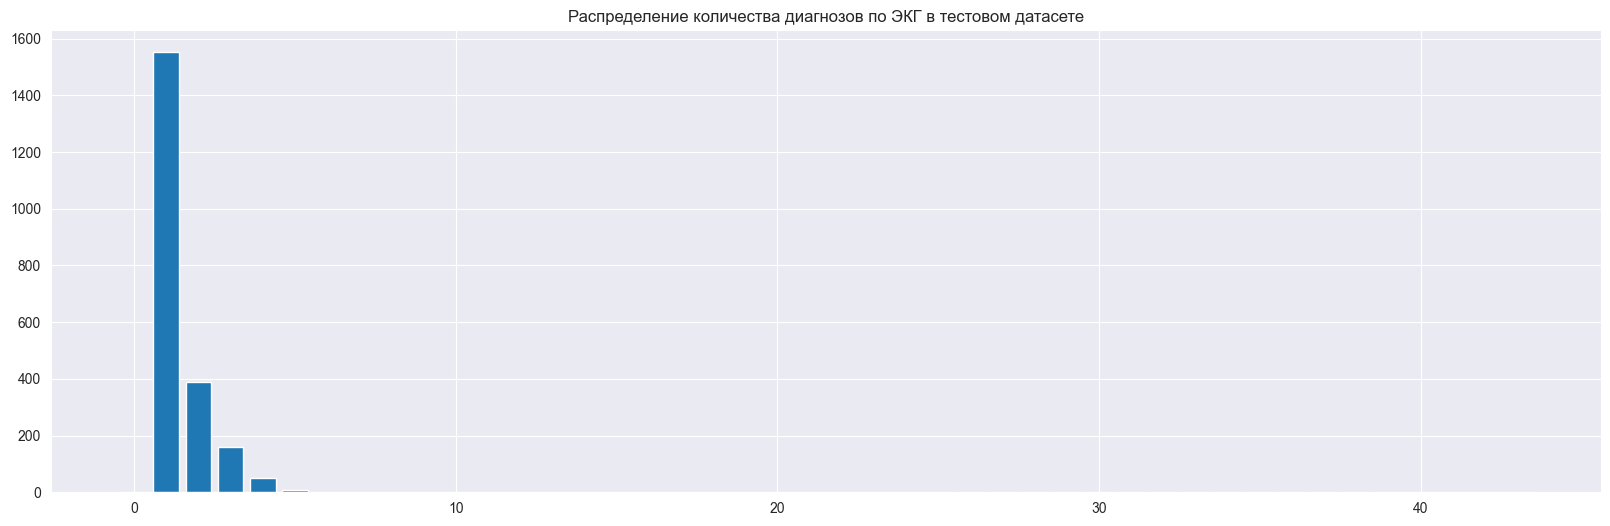

{0: 0.0, 1: 1552.0, 2: 388.0, 3: 161.0, 4: 52.0, 5: 9.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0}


In [10]:
num_classes_row(Y_train, 'обучающем')
num_classes_row(Y_test, 'тестовом')

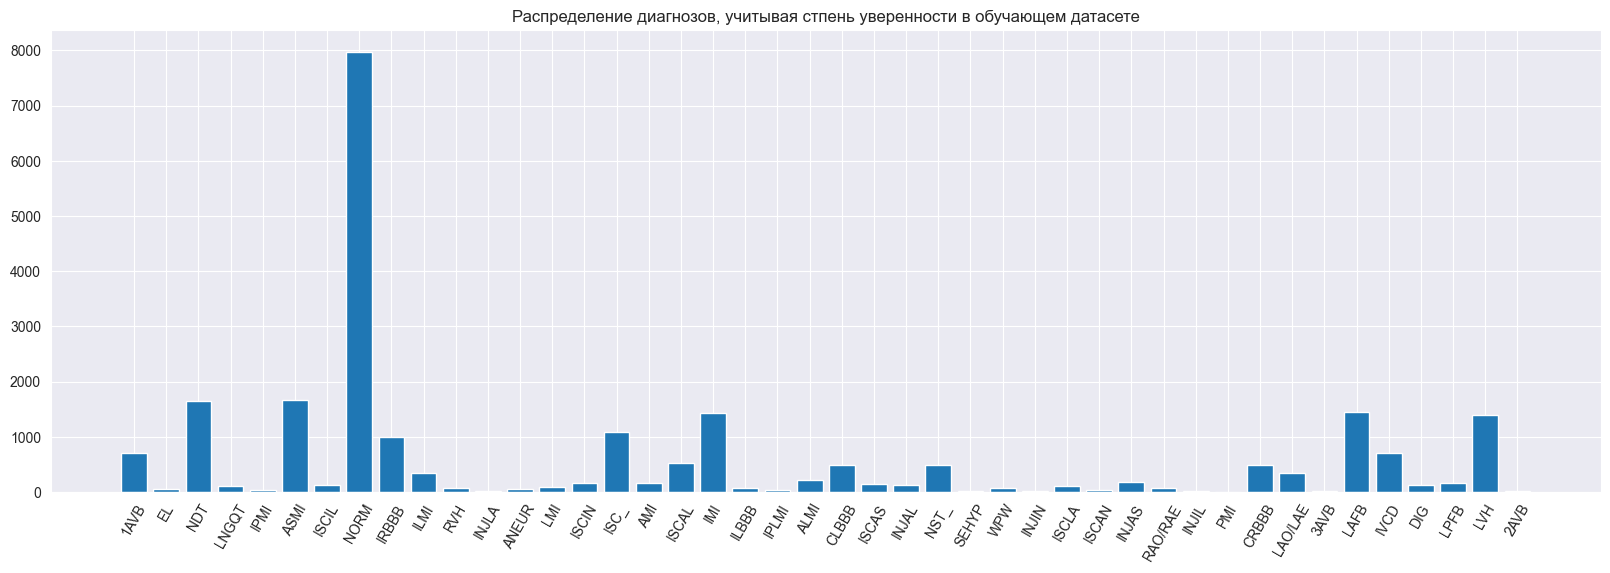

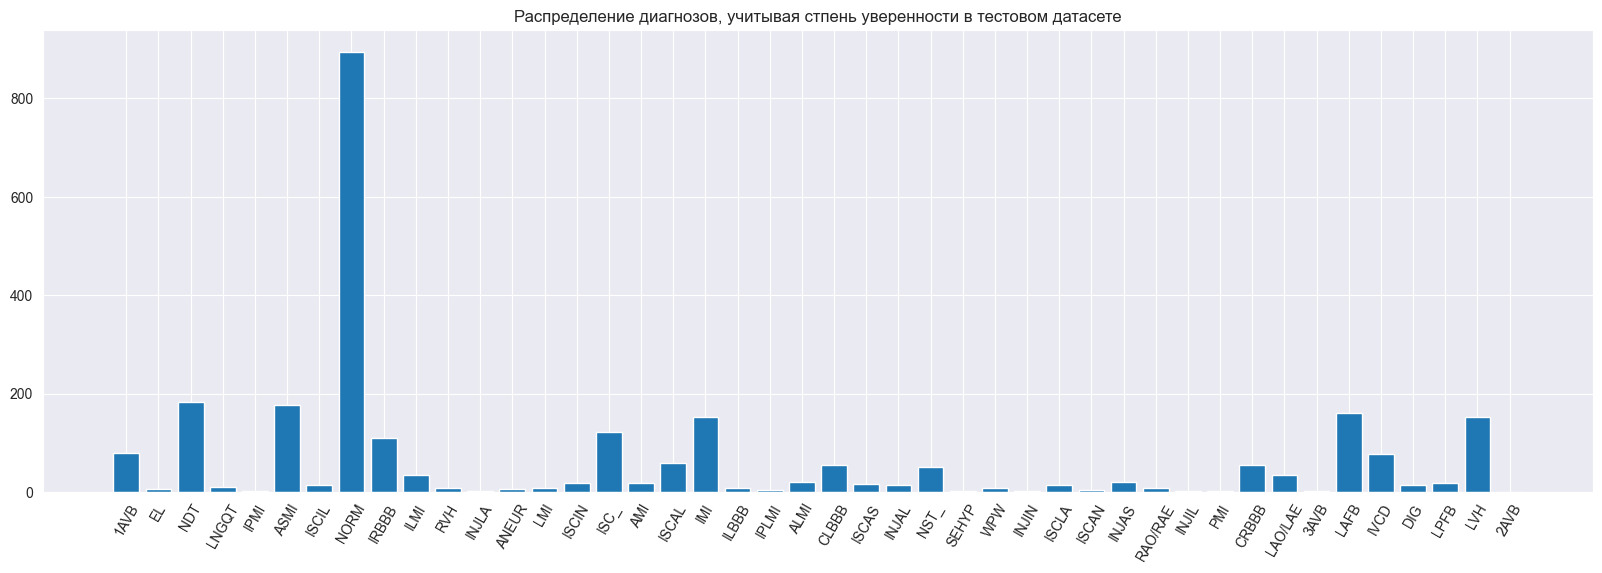

In [11]:
sum_coef_classes_dataset(Y_train, 'обучающем')
sum_coef_classes_dataset(Y_test, 'тестовом')

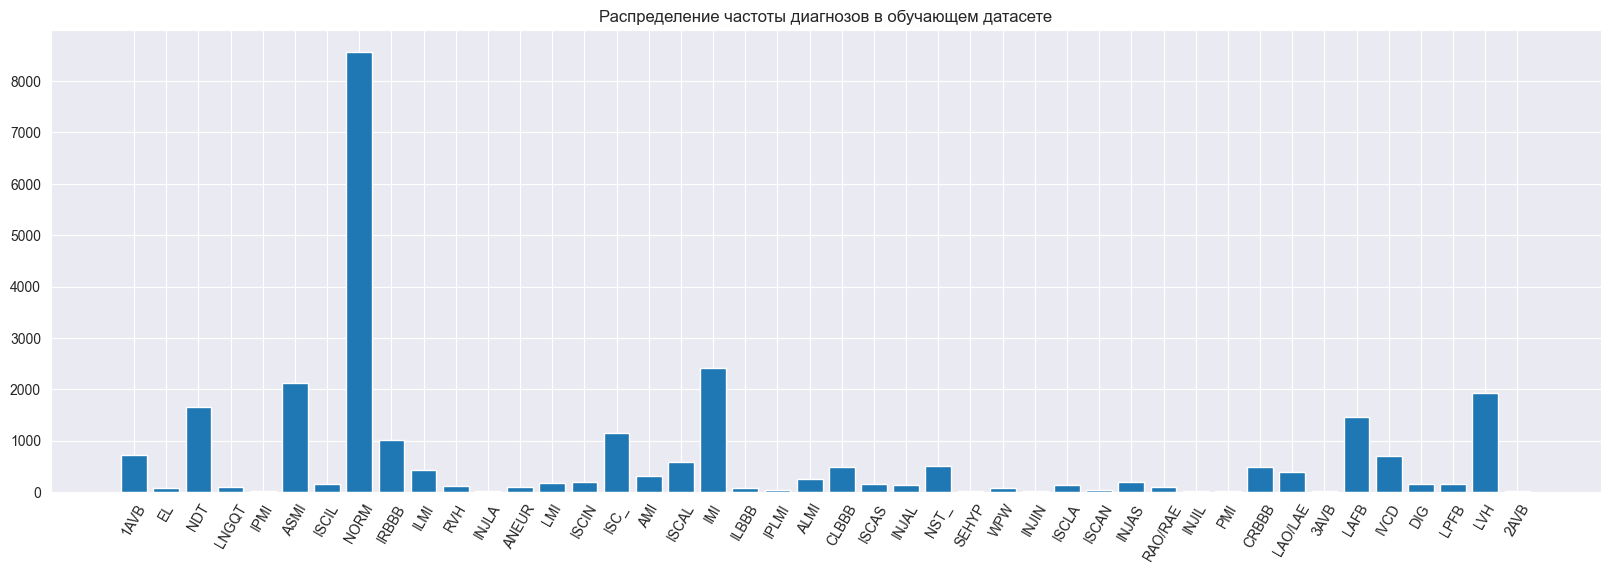

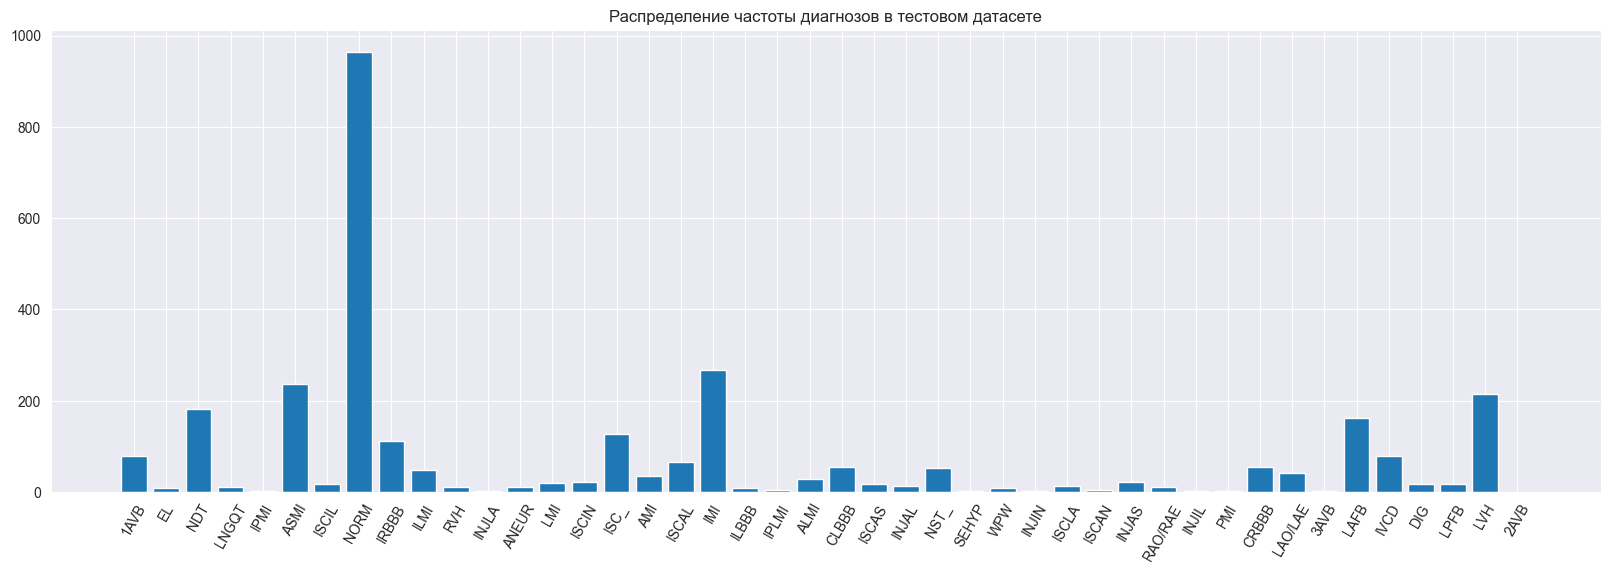

In [12]:
num_classes_dataset(Y_train, 'обучающем')
num_classes_dataset(Y_test, 'тестовом')

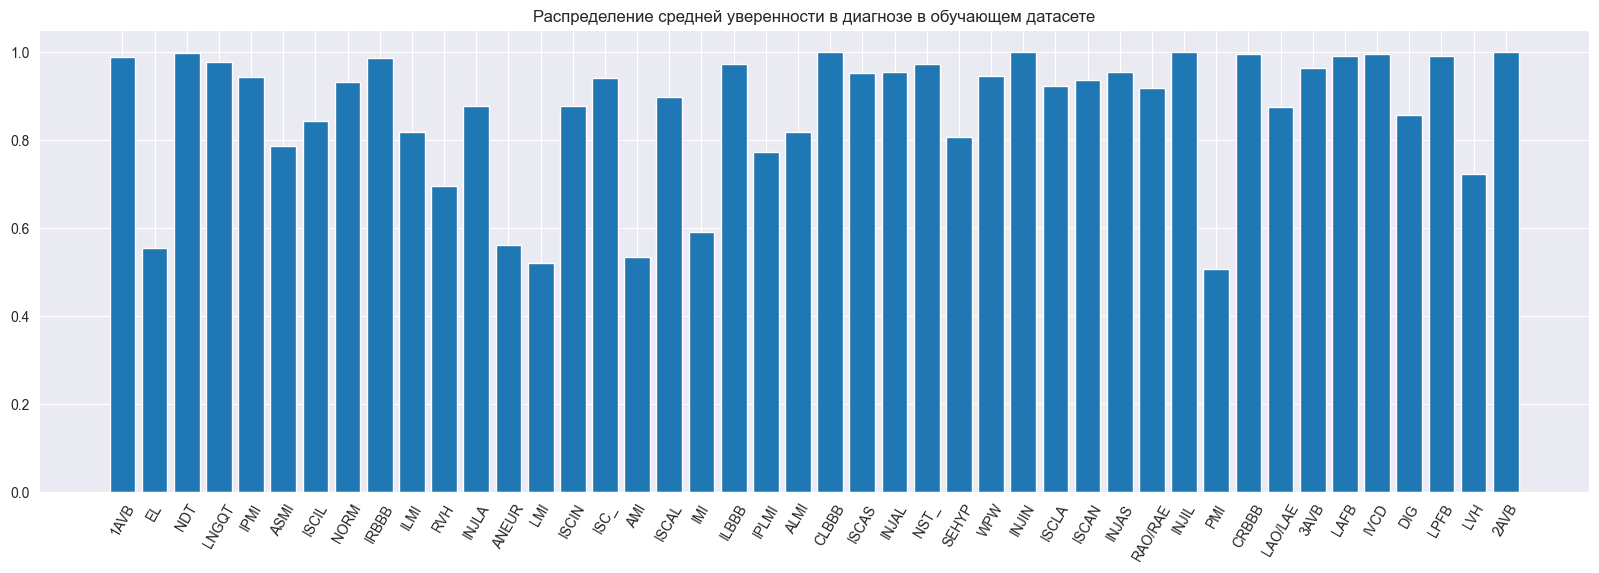

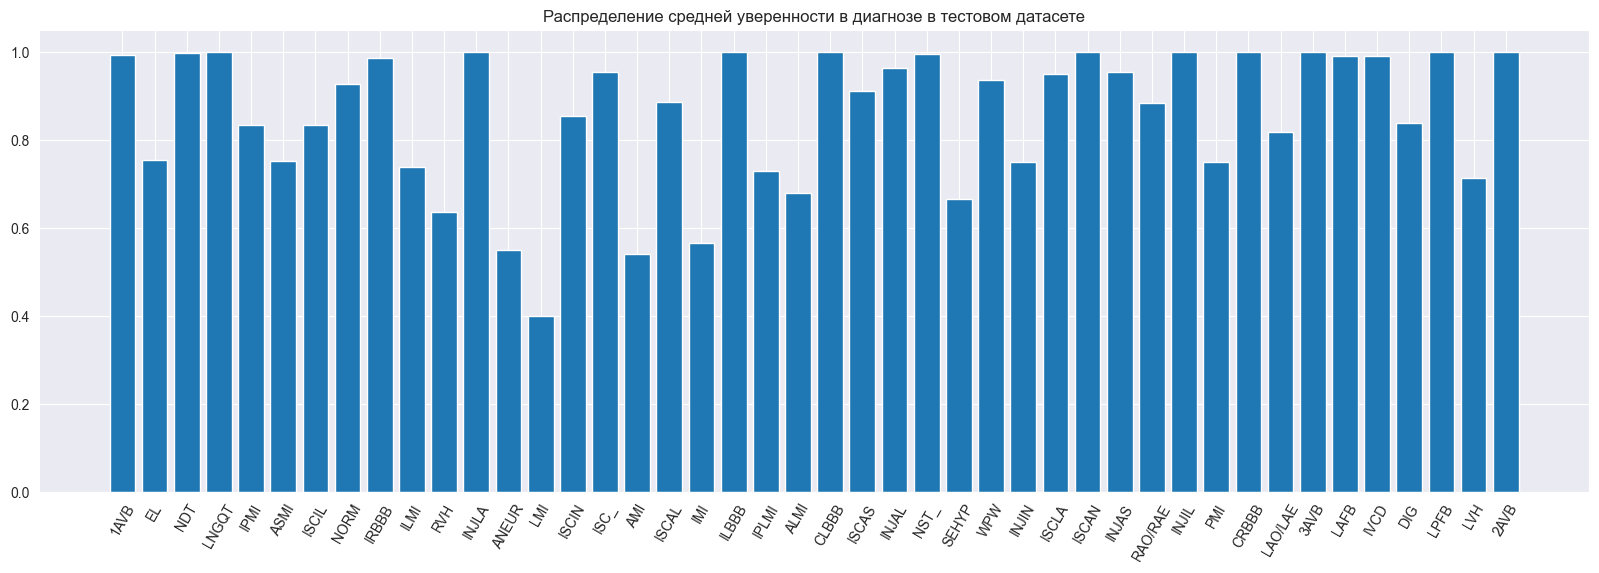

In [13]:
avg_coef_classes_dataset(Y_train, 'обучающем')
avg_coef_classes_dataset(Y_test, 'тестовом')

## Балансировка обучающего датасета

#### Определение авторского метода балансировки

In [14]:
def Prob(x, threshold_inf):
    if x <= threshold_inf:
        return 0
    return 1 / (1 + math.exp(-math.log(x)))


def get_information(values, distribution_0):
    arr = np.zeros(len(values))
    for i in range(len(arr)):
        arr[i] = -math.log(abs(values[i] - 1/distribution_0[i]))        
    return np.sqrt(np.mean(arr**2))


def multiply(dataX, dataY, threshold_i, threshold_p):
    distribution0 = 1 - (dataY > 0).sum(axis=0)/len(dataY)
    information = [get_information(row, distribution0) for row in dataY]
    multiply_probability = [Prob(information_value,threshold_i) for information_value in information]
    dataY = list(dataY)
    dataX = list(dataX)
    for i in range(len(dataY)):
        if random.random() < multiply_probability[i] and multiply_probability[i] > threshold_p:
            dataY.append(dataY[i])
            dataX.append(dataX[i])
    return (np.array(dataX), np.array(dataY))

In [15]:
def create_dataset(n_sample=1000):
    ''' 
    Create a unevenly distributed sample data set multilabel  
    classification using make_classification function
    
    args
    nsample: int, Number of sample to be created
    
    return
    X: pandas.DataFrame, feature vector dataframe with 10 features 
    y: pandas.DataFrame, target vector dataframe with 5 labels
    '''
    X, y = make_classification(n_classes=5, class_sep=2,
                               weights=[0.1,0.025, 0.205, 0.008, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                               n_features=10, n_clusters_per_class=1, n_samples=1000, random_state=10)
    y = pd.get_dummies(y, prefix='class')
    return pd.DataFrame(X), y

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

#### Балансировка

#### Авторский метод

In [16]:
Y_train_balanced = Y_train
X_train_balanced = X_train

In [17]:
Y_train_balanced.sum(axis=1).shape

(19255,)

In [18]:
print('изначальное распределение количества классов для примера %s' % Counter(Y_train_balanced.sum(axis=1)))
print('изначальное распределение вероятности классов', *Y_train_balanced.sum(axis=0)/len(Y_train_balanced))
print('изначальное распределение редкости классов', *max(Y_train_balanced.sum(axis=0))/Y_train_balanced.sum(axis=0))


изначальное распределение количества классов для примера Counter({1.0: 10292, 2.0: 2139, 0.8: 1594, 0.5: 937, 1.5: 709, 0.15: 679, 3.0: 653, 1.15: 425, 2.5: 330, 1.8: 239, 4.0: 201, 0.35: 178, 2.15: 161, 3.5: 111, 1.35: 85, 0.65: 78, 3.15: 45, 5.0: 43, 1.65: 43, 0.3: 35, 4.5: 34, 2.35: 26, 2.8: 25, 0.85: 22, 1.3: 21, 2.3: 18, 1.6: 15, 2.65: 14, 1.2999999999999998: 13, 1.85: 11, 2.6: 11, 3.3: 9, 4.15: 8, 0.9500000000000001: 6, 3.35: 6, 3.8: 5, 3.5999999999999996: 5, 3.65: 3, 2.85: 2, 1.7999999999999998: 2, 0.7: 2, 4.35: 2, 1.7000000000000002: 2, 4.3: 2, 2.7: 2, 1.95: 1, 3.1: 1, 1.34: 1, 3.4000000000000004: 1, 1.1: 1, 1.4500000000000002: 1, 1.5499999999999998: 1, 2.14: 1, 2.1: 1, 2.95: 1, 4.8: 1, 3.85: 1})
изначальное распределение вероятности классов 0.03684237860296027 0.002534406647623994 0.0853622435730979 0.005380420669955855 0.0014697481173721113 0.0868553622435733 0.007060503765255777 0.41399324850689173 0.051594391067255246 0.018299143079719547 0.004115814074266424 0.000682939496

In [19]:
for i in range(20):
    X_train_balanced, Y_train_balanced = multiply(X_train_balanced, Y_train_balanced, 0.9, 0.1)
    print('\n')
    print(f"Длина датасета на шаге {i+1} {len(Y_train_balanced)}")
    print(f'Распределение редкости классов на шаге {i+1} {max(Y_train_balanced.sum(axis=0))/Y_train_balanced.sum(axis=0)}')



Длина датасета на шаге 1 19658
Распределение редкости классов на шаге 1 [ 10.02192607 148.16802974   4.83806634  65.01990212 193.01307506
   4.5448502   53.51755623   1.           7.73588238  21.9085887
  76.46465228 416.26318538 133.52495812  75.17389664  39.72808373
   7.06907285  43.38198639  13.92026543   5.45111635  82.90629225
 160.71451613  33.92824005  16.04557166  46.41304221  48.56192507
  15.6702182  250.67421384 112.27380282 295.23851852  57.28666906
 136.26393162  33.24203503  76.79614644 419.54947368 830.35833333
  14.50407569  20.09437862 408.79179487   5.3151792   10.48321936
  48.66568987  36.31635535   5.50646911 379.59238095]


Длина датасета на шаге 2 20155
Распределение редкости классов на шаге 2 [  8.80488182 134.43406408   4.8383698   52.93452855 123.98040435
   4.2711779   45.82891636   1.           7.39203486  20.76837306
  54.69598628 283.19502664 116.89061584  64.71255784  32.98961308
   6.68618636  40.38470111  13.01222558   5.31250167  62.20788139
 129.41

#### MLSMOTE

In [20]:
ter = torch.tensor(X_train, dtype=torch.float32)
flat = torch.flatten(ter, 1)

In [21]:
a = pd.DataFrame(flat)
b = pd.DataFrame(Y_train > 0)

In [22]:
X_sub, y_sub = get_minority_samples(a, b)  # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 10000, 10)  # Applying MLSMOTE to augment the dataframe

X_res = np.array(X_res)
y_res = np.array(y_res)

X_res = torch.tensor(X_res, dtype=torch.float32)
X_res = X_res.view(-1, 12, 1000)
X_res = np.array(X_res)

X_train_balanced_MLSMOTE = np.concatenate((X_train, X_res), axis=0)
Y_train_balanced_MLSMOTE = np.concatenate((Y_train, y_res), axis=0)

#### Результат балансировки

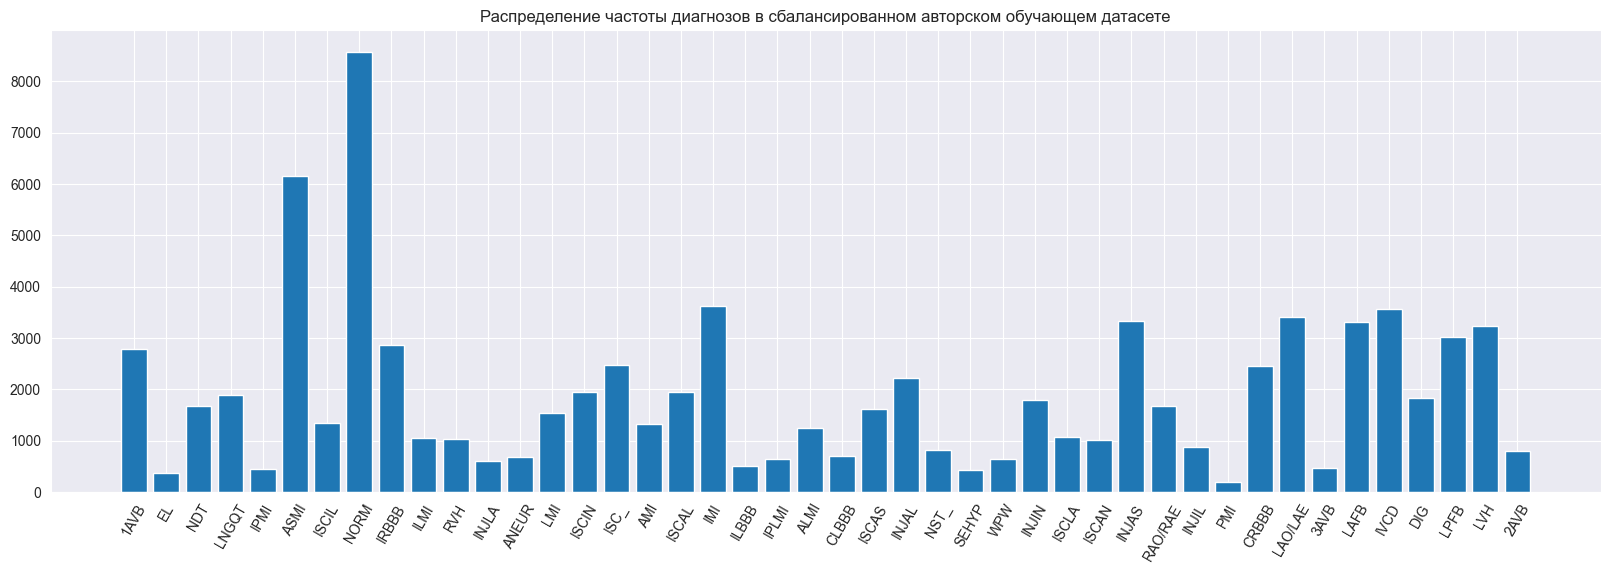

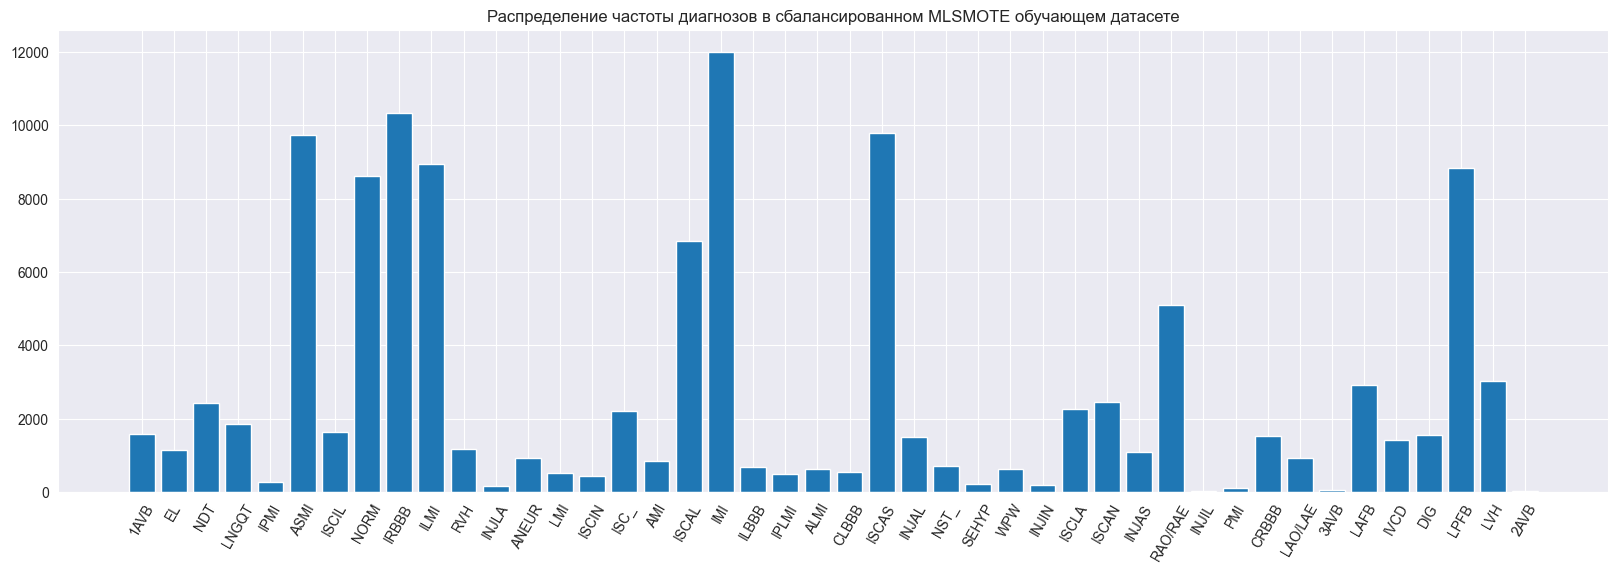

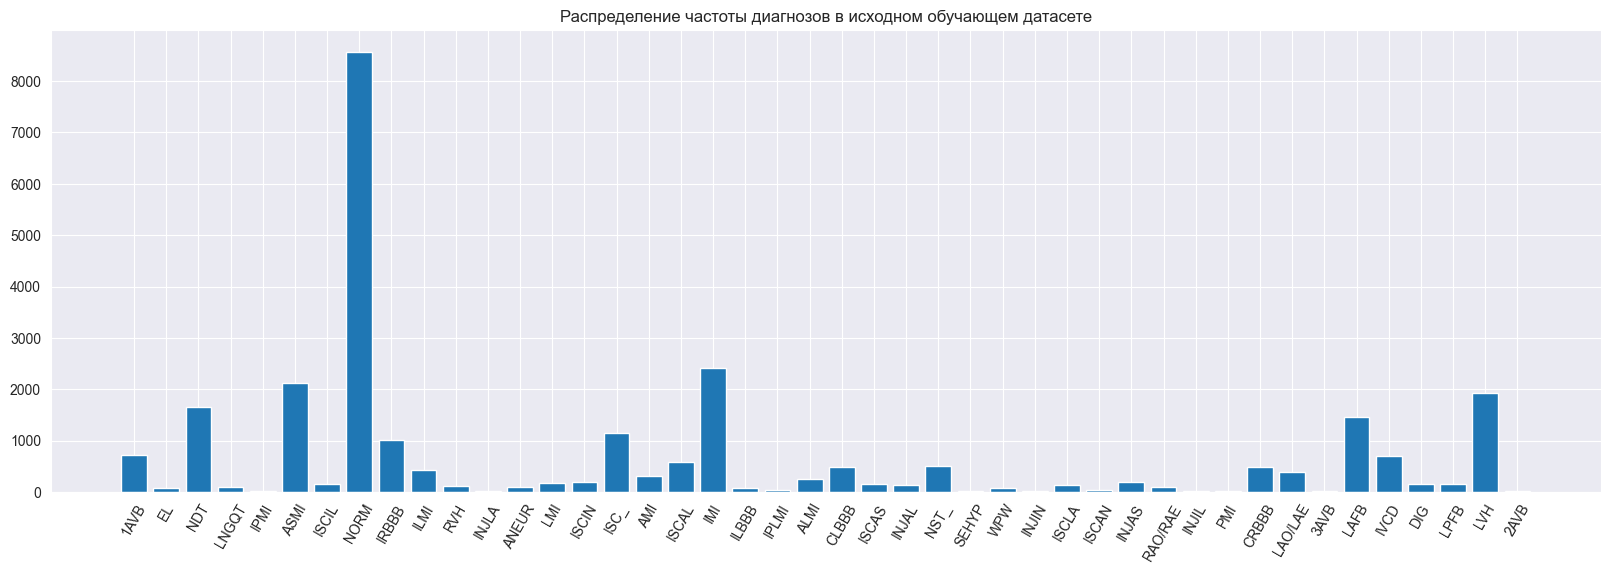

In [23]:
num_classes_dataset(Y_train_balanced, 'сбалансированном авторском обучающем')
num_classes_dataset(Y_train_balanced_MLSMOTE, 'сбалансированном MLSMOTE обучающем')
num_classes_dataset(Y_train, 'исходном обучающем')

## Подготовка моделей классификатора

### Подготовка загрузчиков данных

In [24]:
Y_train1 = Y_train > 0
Y_train_balanced1 = Y_train_balanced > 0
Y_train_balanced_MLSMOTE1 = Y_train_balanced_MLSMOTE > 0
Y_test1 = Y_test > 0

In [25]:
X_train1 = X_train.transpose(0,2,1)
X_train_balanced1 = X_train_balanced.transpose(0,2,1)
X_train_balanced_MLSMOTE1 = X_train_balanced_MLSMOTE.transpose(0,2,1)
X_test1 = X_test.transpose(0,2,1)

In [26]:
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
Y_train1 = torch.tensor(Y_train1, dtype=torch.float32)
X_train_balanced1 = torch.tensor(X_train_balanced1, dtype=torch.float32)
Y_train_balanced1 = torch.tensor(Y_train_balanced1, dtype=torch.float32)
X_train_balanced_MLSMOTE1 = torch.tensor(X_train_balanced_MLSMOTE1, dtype=torch.float32)
Y_train_balanced_MLSMOTE1 = torch.tensor(Y_train_balanced_MLSMOTE1, dtype=torch.float32)
X_test1 = torch.tensor(X_test1, dtype=torch.float32)
Y_test1 = torch.tensor(Y_test1, dtype=torch.float32)

batch = 256

Train_basic = torch.utils.data.DataLoader(tuple(zip(X_train1, Y_train1)), batch_size=batch, shuffle=True)
Train_balanced = torch.utils.data.DataLoader(tuple(zip(X_train_balanced1, Y_train_balanced1)), batch_size=batch, shuffle=True)
Train_balanced_MLSMOTE = torch.utils.data.DataLoader(tuple(zip(X_train_balanced_MLSMOTE1, Y_train_balanced_MLSMOTE1)), batch_size=batch, shuffle=True)
Test = torch.utils.data.DataLoader(tuple(zip(X_test1, Y_test1)), batch_size=batch)



### Функция обучения

In [27]:
def train_model(model, learning_rate, train, test, epoch_num, metrics_threshold, label,
                metric_funcs, verbose=False, plot=True):
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
    
    hist_train = np.zeros(epoch_num)
    hist_test = np.zeros(epoch_num)
    metrics_train = np.zeros((epoch_num, len(metric_funcs), len(diagnose_set)))
    metrics_test = np.zeros((epoch_num, len(metric_funcs), len(diagnose_set)))
    
    
    for i in range(epoch_num):      
        
        hist_train_epoch = 0
        Pred_train = np.empty((1, len(diagnose_set)))
        Real_train = np.empty((1, len(diagnose_set)))
        
        model.train()
        for j, (X, Y) in enumerate(train): 
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()
            
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()
            
            hist_train_epoch += loss.item()
            Y_threshold = torch.sigmoid(Y_pred) >= metrics_threshold
            Pred_train = np.concatenate((Pred_train, Y_threshold.cpu().detach().numpy()))
            Real_train = np.concatenate((Real_train, Y.cpu().detach().numpy()))

            if verbose:
                print(f"Пройден обучающий батч {j} из {len(train)}", end='\r')
        print('\n')
        
        
        hist_test_epoch = 0
        Pred_test = np.empty((1, len(diagnose_set)))
        Real_test = np.empty((1, len(diagnose_set)))
        
        model.eval()
        for j, (X, Y) in enumerate(test):
            X = X.to(device)
            Y = Y.to(device)            
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)

            hist_test_epoch += loss.item()
            Y_threshold = torch.sigmoid(Y_pred) >= metrics_threshold
            Pred_test = np.concatenate((Pred_test, Y_threshold.cpu().detach().numpy()))
            Real_test = np.concatenate((Real_test, Y.cpu().detach().numpy()))

            if verbose:
                print(f"Пройден тестовый батч {j} из {len(test)}", end='\r')
        print('\n')

        
        Pred_train = Pred_train[1:]
        Pred_test = Pred_test[1:]
        Real_train = Real_train[1:]
        Real_test = Real_test[1:]

        for j, metric in enumerate(metric_funcs):
            for k, (pred_col, trg_col) in enumerate(zip(Pred_train.T, Real_train.T)):
                metrics_train[i,j,k] = metric(pred_col, trg_col)

        for j, metric in enumerate(metric_funcs):
            for k, (pred_col, trg_col) in enumerate(zip(Pred_test.T, Real_test.T)):
                metrics_test[i,j,k] = metric(pred_col, trg_col)
        

        hist_train[i] = hist_train_epoch/len(train)
        hist_test[i] = hist_test_epoch/len(test)

        if verbose:
            if (i) % verbose == 0:
                print(f"Пройдена эпоха {i+1} из {epoch_num}, результаты:")
                print(f"Loss Train / Test: {hist_train[i]} / {hist_test[i]}")
                for j, metric in enumerate(metric_funcs):
                    tmp_dict_train = {key: value for key, value in zip(diagnose_set, metrics_train[i, j, :])}
                    tmp_dict_test = {key: value for key, value in zip(diagnose_set, metrics_test[i, j, :])}
                    print(f"Обучающая выборка - значения метрики {metric.__name__} на итерации {i+1} = \n {tmp_dict_train}")
                    print(f"Тестовая выборка - значения метрики {metric.__name__} на итерации {i+1} = \n {tmp_dict_test}")

    if plot:
        plt.figure(figsize=(16, 6))        
        plt.plot(hist_test, label=f"Loss test {label}")
        plt.plot(hist_train, label=f"Loss train {label}")
        plt.grid()
        plt.legend()
        

    return (hist_train, hist_test, metrics_train, metrics_test)

### Подготовка Рекурентной модели

In [28]:
class Network_gru(torch.nn.Module):
    def __init__(self, hidden, layers):
        super().__init__()
        self.gru2 = torch.nn.GRU(input_size=12, hidden_size=hidden, batch_first=True, bidirectional=True, num_layers=layers, dropout=0.25)

        self.flatten = torch.nn.Flatten()
        self.head = torch.nn.Linear(layers*2*hidden, len(diagnose_set))
        
    def forward(self, X):
        _, s3 = self.gru2(X)
        flat = self.flatten(torch.transpose(s3, 0, 1))
        out = self.head(flat)
        return out

criterion = torch.nn.BCEWithLogitsLoss()

Пройден обучающий батч 75 из 76

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 40, результаты:
Loss Train / Test: 0.16519802642103873 / 0.1052898806002405
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9617761620358348, 'EL': 0.9952220202544794, 'NDT': 0.8950402492858998, 'LNGQT': 0.9942352635679045, 'IPMI': 0.9962607115035056, 'ASMI': 0.8799272916125682, 'ISCIL': 0.9743962607115035, 'NORM': 0.5443780836146456, 'IRBBB': 0.9469228771747598, 'ILMI': 0.9726824201506102, 'RVH': 0.9828615943910672, 'INJLA': 0.9777200727083875, 'ANEUR': 0.9933523760062322, 'LMI': 0.9895092183848351, 'ISCIN': 0.9893014801350298, 'ISC_': 0.93544533887302, 'AMI': 0.9793819787068294, 'ISCAL': 0.9691508699039211, 'IMI': 0.8638275772526617, 'ILBBB': 0.9964165151908595, 'IPLMI': 0.9973513373149832, 'ALMI': 0.9759023630225915, 'CLBBB': 0.9397039729940275, 'ISCAS': 0.9917943391326928, 'INJAL': 0.9769410542716178, 'NST_': 0.9495715398597767, 'SEHYP': 0.9735653077122826, 'WPW': 0.9

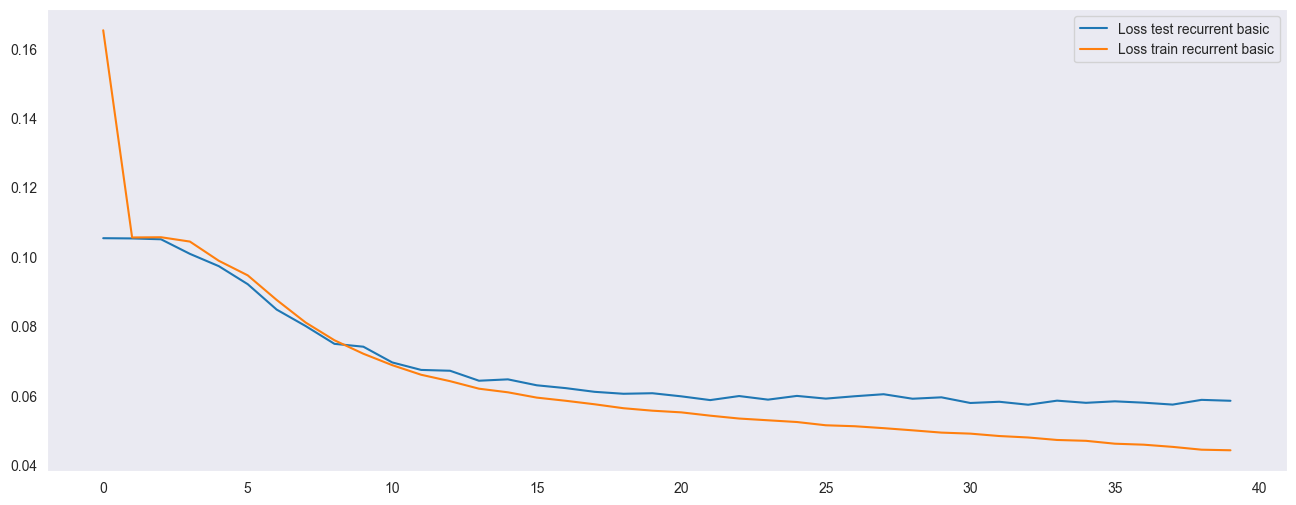

In [29]:
model_gru_basic = Network_gru(64, 4)
recurent_res_basic = train_model(model_gru_basic, 0.001, Train_basic, Test, 40, 0.5, 'recurrent basic', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

Пройден обучающий батч 131 из 132

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 25, результаты:
Loss Train / Test: 0.2234498824585568 / 0.12788918283250597
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9170061554015879, 'EL': 0.9822474649855779, 'NDT': 0.9377323143715246, 'LNGQT': 0.942103541586131, 'IPMI': 0.9794522584673943, 'ASMI': 0.813880876624342, 'ISCIL': 0.9588747806952332, 'NORM': 0.7444764935026317, 'IRBBB': 0.9160248594962681, 'ILMI': 0.9619970858485236, 'RVH': 0.96943114573731, 'INJLA': 0.9745755151803502, 'ANEUR': 0.9795414671860596, 'LMI': 0.9484076243718219, 'ISCIN': 0.9334502958755836, 'ISC_': 0.922328942281959, 'AMI': 0.9534330488566416, 'ISCAL': 0.928662761307205, 'IMI': 0.8807874156234202, 'ILBBB': 0.9849237265455411, 'IPLMI': 0.97451604270124, 'ALMI': 0.9631567991911743, 'CLBBB': 0.9736536917541407, 'ISCAS': 0.9419548603883553, 'INJAL': 0.9344018555413482, 'NST_': 0.9752594486901186, 'SEHYP': 0.9822474649855779, 'WPW': 0.96729

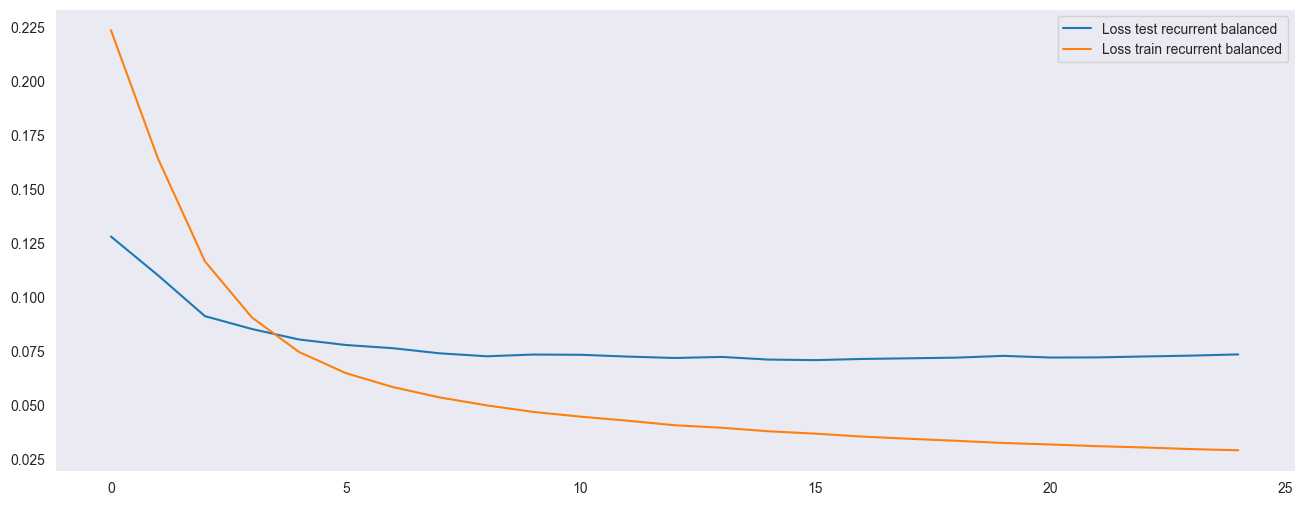

In [30]:
model_gru_balanced = Network_gru(64, 4)
recurent_res_balanced = train_model(model_gru_balanced, 0.001, Train_balanced, Test, 25, 0.5, 'recurrent balanced', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

Пройден обучающий батч 114 из 115

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 25, результаты:
Loss Train / Test: 0.2698893043010131 / 0.16640610992908478
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9440779353956589, 'EL': 0.9549820543496839, 'NDT': 0.9094171936421125, 'LNGQT': 0.936455306785165, 'IPMI': 0.9870791317723466, 'ASMI': 0.6667578191762092, 'ISCIL': 0.9330370876773201, 'NORM': 0.7046316868911298, 'IRBBB': 0.6471714236882584, 'ILMI': 0.688019142027004, 'RVH': 0.9527260297385063, 'INJLA': 0.9778841223722441, 'ANEUR': 0.967732011621945, 'LMI': 0.9698513074688088, 'ISCIN': 0.9848572893522475, 'ISC_': 0.9162536318578021, 'AMI': 0.9707400444368484, 'ISCAL': 0.762467954195864, 'IMI': 0.5903948043069561, 'ILBBB': 0.9681421979148863, 'IPLMI': 0.974294992309007, 'ALMI': 0.9727567937104769, 'CLBBB': 0.9777132114168519, 'ISCAS': 0.6667920013672877, 'INJAL': 0.9304050589642796, 'NST_': 0.9666723636985131, 'SEHYP': 0.9923773713895061, 'WPW': 0.97

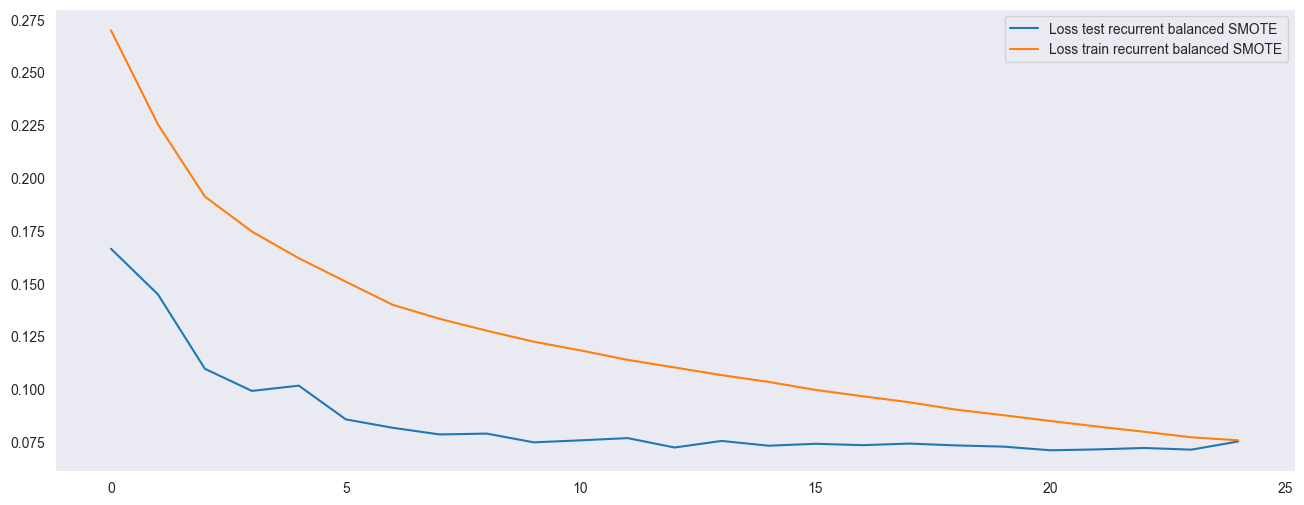

In [31]:
model_gru_balanced_MLSMOTE = Network_gru(64, 4)
recurent_res_balanced_MLSMOT = train_model(model_gru_balanced_MLSMOTE, 0.001, Train_balanced_MLSMOTE, Test, 25, 0.5, 'recurrent balanced SMOTE', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

### Подготовка свёрточной модели

In [32]:

X_train2 = torch.tensor(X_train, dtype=torch.float32)
X_train_balanced2 = torch.tensor(X_train_balanced, dtype=torch.float32)
X_train_balanced_MLSMOTE2 = torch.tensor(X_train_balanced_MLSMOTE, dtype=torch.float32)
X_test2 = torch.tensor(X_test, dtype=torch.float32)


batch = 256

Train_basic_conv = torch.utils.data.DataLoader(tuple(zip(X_train2, Y_train1)), batch_size=batch, shuffle=True)
Train_balanced_conv = torch.utils.data.DataLoader(tuple(zip(X_train_balanced2, Y_train_balanced1)), batch_size=batch, shuffle=True)
Train_balanced_MLSMOTE_conv = torch.utils.data.DataLoader(tuple(zip(X_train_balanced_MLSMOTE2, Y_train_balanced_MLSMOTE1)), batch_size=batch, shuffle=True)
Test_conv = torch.utils.data.DataLoader(tuple(zip(X_test2, Y_test1)), batch_size=batch)



In [33]:
Network_basic_conv = torch.nn.Sequential(
    torch.nn.Conv1d(12, 48, 7, padding=3, stride=3),
    torch.nn.ReLU(),
    torch.nn.Dropout1d(0.25),
    torch.nn.Conv1d(48, 128, 5, padding=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(3, stride=2),
    torch.nn.Dropout1d(0.25),
    torch.nn.Conv1d(128, 256, 3, padding=1, stride=1),
    torch.nn.MaxPool1d(3, stride=2),
    torch.nn.Dropout1d(0.25),
    torch.nn.Conv1d(256, 512, 3, padding=1, stride=1),
    torch.nn.AvgPool1d(3, stride=2),
    torch.nn.Dropout1d(0.25),
    torch.nn.Conv1d(512, 128, 5, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(1024, len(diagnose_set))
)

criterion = torch.nn.BCEWithLogitsLoss()

buffer = io.BytesIO()
torch.save(Network_basic_conv, buffer) 
print(buffer.tell()) 

del Network_basic_conv

3607617


Пройден обучающий батч 75 из 76

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 40, результаты:
Loss Train / Test: 0.13759591293178106 / 0.10193993979030186
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9622435730978967, 'EL': 0.9953258893793819, 'NDT': 0.9039210594650741, 'LNGQT': 0.9939755907556479, 'IPMI': 0.9893014801350298, 'ASMI': 0.8895351856660607, 'ISCIL': 0.9915866008828875, 'NORM': 0.5353934043105687, 'IRBBB': 0.9385094780576474, 'ILMI': 0.9776162035834848, 'RVH': 0.9807842118930148, 'INJLA': 0.9973513373149832, 'ANEUR': 0.9822903142041028, 'LMI': 0.9905998441963126, 'ISCIN': 0.9765775123344586, 'ISC_': 0.9389768891197091, 'AMI': 0.9698260192157881, 'ISCAL': 0.9672812256556739, 'IMI': 0.8736951441184108, 'ILBBB': 0.9923656193196573, 'IPLMI': 0.9833809400155804, 'ALMI': 0.97465593352376, 'CLBBB': 0.9625551804726045, 'ISCAS': 0.9795377823941833, 'INJAL': 0.9797455206439886, 'NST_': 0.9735133731498312, 'SEHYP': 0.9822903142041028, 'WPW': 0.

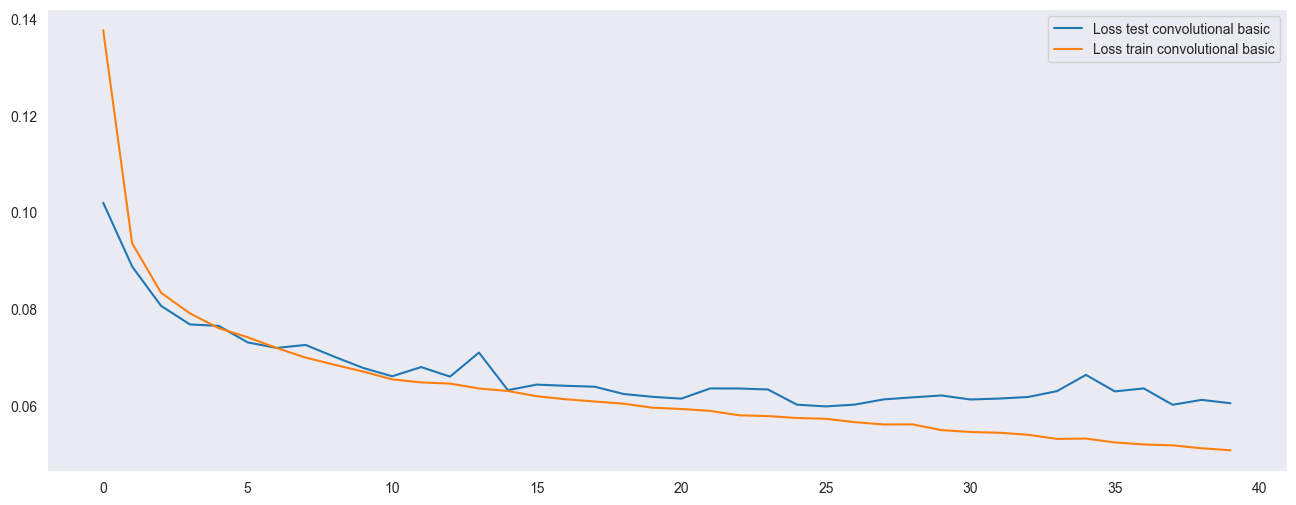

In [34]:
buffer.seek(0)
model_conv_basic = torch.load(buffer)

recurent_res_basic = train_model(model_conv_basic, 0.001, Train_basic_conv, Test_conv, 40, 0.5, 'convolutional basic', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

Пройден обучающий батч 131 из 132

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 25, результаты:
Loss Train / Test: 0.20541011395327974 / 0.0992915572391616
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9167087930060365, 'EL': 0.9886110202503792, 'NDT': 0.9436498260429986, 'LNGQT': 0.9433524636474472, 'IPMI': 0.9810580154033721, 'ASMI': 0.8227125397722204, 'ISCIL': 0.9634838978262809, 'NORM': 0.7483719408843558, 'IRBBB': 0.9101965565434595, 'ILMI': 0.9687472122275417, 'RVH': 0.9626215468791817, 'INJLA': 0.981028279163817, 'ANEUR': 0.972464242171935, 'LMI': 0.9570608700823694, 'ISCIN': 0.9356507776026644, 'ISC_': 0.9279490915578816, 'AMI': 0.9530762139819798, 'ISCAL': 0.9411519819203663, 'IMI': 0.8919682416961551, 'ILBBB': 0.9823366737042434, 'IPLMI': 0.9739510541496922, 'ALMI': 0.9568527164054834, 'CLBBB': 0.9720479348181629, 'ISCAS': 0.9458205715305242, 'INJAL': 0.9271462130898926, 'NST_': 0.9757947010021113, 'SEHYP': 0.9794225222278391, 'WPW': 0

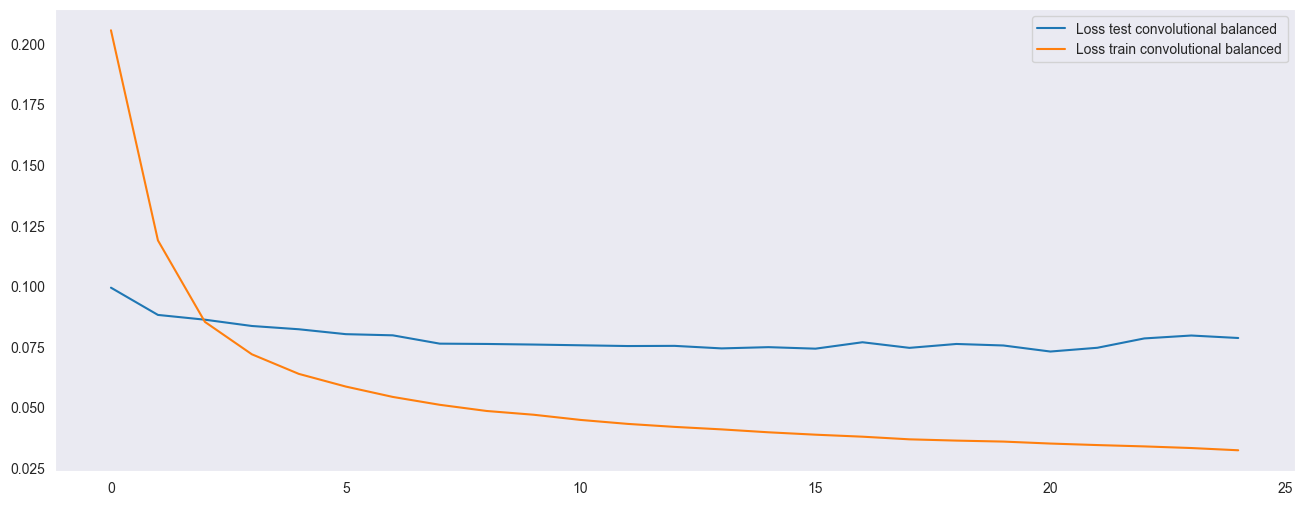

In [35]:
buffer.seek(0)
model_conv_balanced = torch.load(buffer)

recurent_res_balanced = train_model(model_conv_balanced, 0.001, Train_balanced_conv, Test_conv, 25, 0.5, 'convolutional balanced', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

Пройден обучающий батч 114 из 115

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 25, результаты:
Loss Train / Test: 0.23236500607884447 / 0.1168301287624571
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9447615792172278, 'EL': 0.9605879336865493, 'NDT': 0.9098957443172108, 'LNGQT': 0.9364894889762434, 'IPMI': 0.9837976414288155, 'ASMI': 0.6944112117586737, 'ISCIL': 0.9440095710135019, 'NORM': 0.7443855751153649, 'IRBBB': 0.7125961374124081, 'ILMI': 0.7259955563151598, 'RVH': 0.9511194667578192, 'INJLA': 0.993061015211075, 'ANEUR': 0.9600410186292941, 'LMI': 0.9820543496838148, 'ISCIN': 0.976277559391557, 'ISC_': 0.9235002563664331, 'AMI': 0.9618526747564519, 'ISCAL': 0.7454452230387968, 'IMI': 0.6869253119124936, 'ILBBB': 0.9735771662963596, 'IPLMI': 0.9745342676465562, 'ALMI': 0.9713553238762604, 'CLBBB': 0.9725517005640062, 'ISCAS': 0.7349854725687917, 'INJAL': 0.9412408135361476, 'NST_': 0.9756280977610665, 'SEHYP': 0.9836267304734233, 'WPW': 0

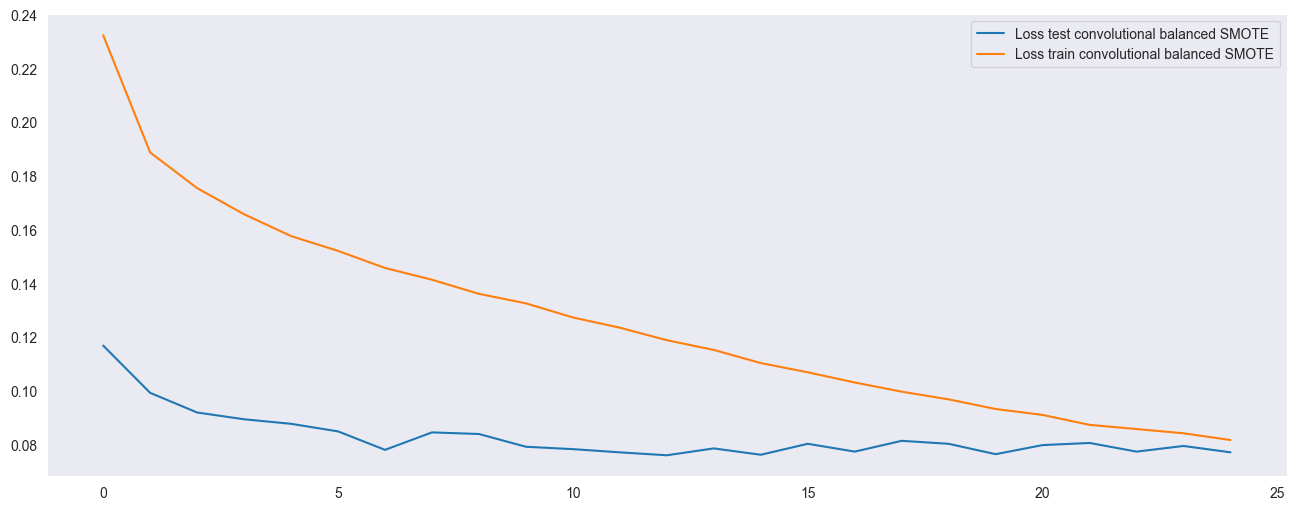

In [36]:
buffer.seek(0)
model_conv_balanced_MLSMOTE = torch.load(buffer)

recurent_res_balanced_MLSMOT = train_model(model_conv_balanced_MLSMOTE, 0.001, Train_balanced_MLSMOTE_conv, Test_conv, 25, 0.5, 'convolutional balanced SMOTE', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

In [37]:
del buffer

### Свёрточная со skip connection 

In [38]:
class resnet_block_1D(torch.nn.Module):
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.forw = torch.nn.Sequential(
            torch.nn.Conv1d(c1, c2, 3, padding=1),
            torch.nn.BatchNorm1d(c2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(c2, c3, 3, padding=1),
            torch.nn.BatchNorm1d(c3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(c3, c4, 3, padding=1),
            torch.nn.BatchNorm1d(c4)
        )
        self.residual = torch.nn.Conv1d(c1, c4, 1)

    def forward(self, x):
        forw = self.forw(x)
        residual = self.residual(x)
        return forw + residual

In [45]:
Network_residual_conv = torch.nn.Sequential(
    resnet_block_1D(12, 24, 36, 48),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(3, stride=2),
    torch.nn.Dropout1d(0.25),
    resnet_block_1D(48, 72, 100, 128),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(3, stride=2),
    torch.nn.Dropout1d(0.25),
    resnet_block_1D(128, 160, 200, 256),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(3, stride=2),
    torch.nn.Dropout1d(0.25),
    resnet_block_1D(256, 320, 400, 512),
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(3, stride=2),
    torch.nn.Dropout1d(0.25),
    resnet_block_1D(512, 680, 850, 1024),
    torch.nn.ReLU(),
    torch.nn.AvgPool1d(61),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(1024, len(diagnose_set))
)

criterion = torch.nn.BCEWithLogitsLoss()

buffer = io.BytesIO()
torch.save(Network_residual_conv, buffer) 
print(buffer.tell()) 

del Network_residual_conv

31205591


Пройден обучающий батч 75 из 76

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 25, результаты:
Loss Train / Test: 0.10202347840133466 / 0.07834580209520128
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9551804726045183, 'EL': 0.9891456764476759, 'NDT': 0.911088029083355, 'LNGQT': 0.9872240976369774, 'IPMI': 0.9854583225136329, 'ASMI': 0.8834588418592574, 'ISCIL': 0.9893534146974812, 'NORM': 0.7480654375486887, 'IRBBB': 0.9325889379381979, 'ILMI': 0.9762659049597507, 'RVH': 0.9832251363282264, 'INJLA': 0.9901324331342508, 'ANEUR': 0.9845235003895092, 'LMI': 0.9893014801350298, 'ISCIN': 0.9897688911970917, 'ISC_': 0.9411581407426642, 'AMI': 0.9761101012723968, 'ISCAL': 0.9671773565307712, 'IMI': 0.8682420150610232, 'ILBBB': 0.9954297585042846, 'IPLMI': 0.9930407686315242, 'ALMI': 0.9860815372630486, 'CLBBB': 0.977304596208777, 'ISCAS': 0.9897169566346403, 'INJAL': 0.9870163593871721, 'NST_': 0.9716956634640354, 'SEHYP': 0.9966761880031161, 'WPW': 0.

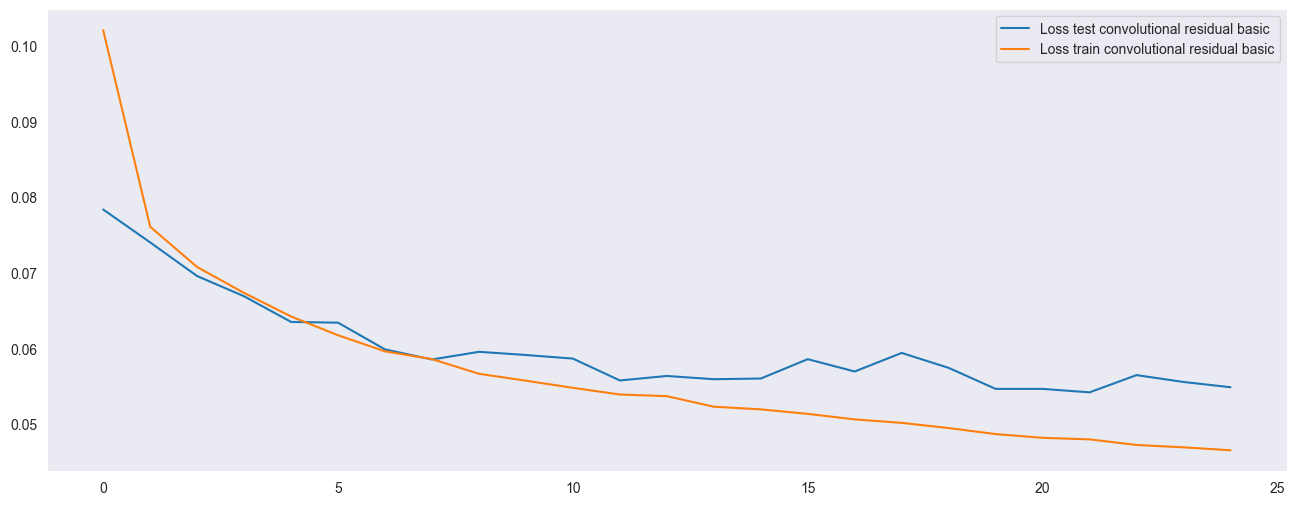

In [46]:
buffer.seek(0)
model_conv_residual_basic = torch.load(buffer)

recurent_res_residual_basic = train_model(model_conv_residual_basic, 0.001, Train_basic_conv, Test_conv, 25, 0.5, 'convolutional residual basic', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

Пройден обучающий батч 131 из 132

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 25, результаты:
Loss Train / Test: 0.13182414131182613 / 0.08188906146420373
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9177792976300218, 'EL': 0.9886110202503792, 'NDT': 0.9454637366558625, 'LNGQT': 0.972464242171935, 'IPMI': 0.9839126944006661, 'ASMI': 0.859942311695263, 'ISCIL': 0.9660114781884683, 'NORM': 0.8608343988819174, 'IRBBB': 0.9196229444824408, 'ILMI': 0.9636325790240566, 'RVH': 0.9720181985786077, 'INJLA': 0.9777275565731958, 'ANEUR': 0.979006214874067, 'LMI': 0.9735644830354754, 'ISCIN': 0.9468910761545095, 'ISC_': 0.9415088167950281, 'AMI': 0.9640786226173838, 'ISCAL': 0.9409438282434803, 'IMI': 0.8887269915846442, 'ILBBB': 0.9840019031193316, 'IPLMI': 0.9843587379939933, 'ALMI': 0.9634244253471705, 'CLBBB': 0.9774004579380892, 'ISCAS': 0.9570608700823694, 'INJAL': 0.9594695054863362, 'NST_': 0.9748431413363466, 'SEHYP': 0.9835855957655595, 'WPW': 0

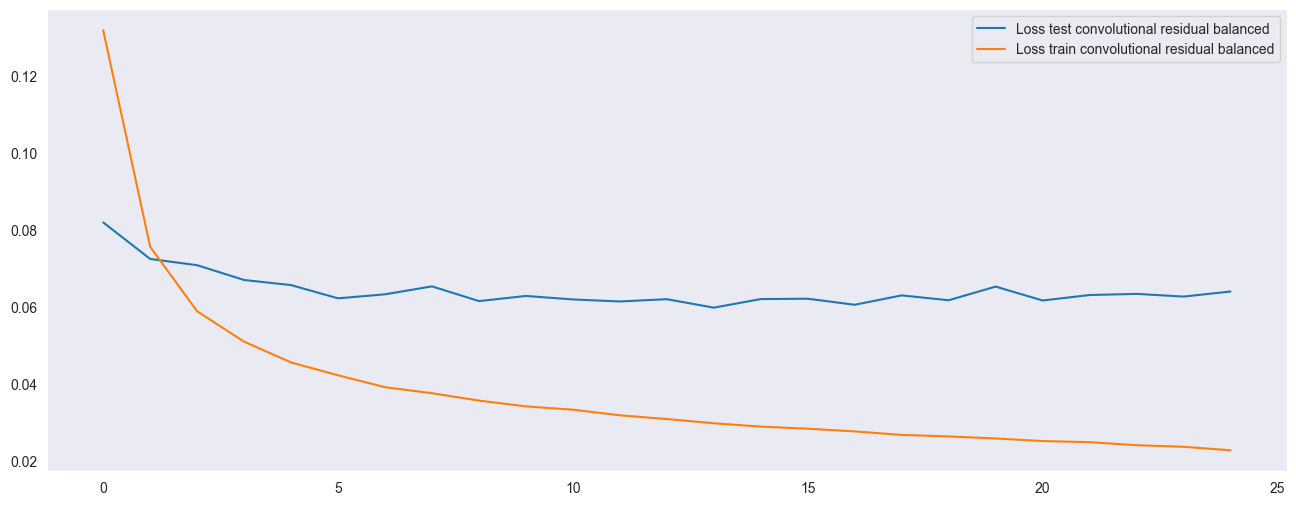

In [41]:
buffer.seek(0)
model_conv_residual_balanced = torch.load(buffer)

recurent_res_residual_balanced = train_model(model_conv_residual_balanced, 0.001, Train_balanced_conv, Test_conv, 25, 0.5, 'convolutional residual balanced', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

Пройден обучающий батч 114 из 115

Пройден тестовый батч 8 из 9

Пройдена эпоха 1 из 25, результаты:
Loss Train / Test: 0.19259882672973302 / 0.0911274113588863
Обучающая выборка - значения метрики accuracy_score на итерации 1 = 
 {'1AVB': 0.9412066313450692, 'EL': 0.9605879336865493, 'NDT': 0.9116390360622116, 'LNGQT': 0.9366262177405572, 'IPMI': 0.9866689454794052, 'ASMI': 0.7490685352931122, 'ISCIL': 0.9399077080840882, 'NORM': 0.8152794394120663, 'IRBBB': 0.8005810972483336, 'ILMI': 0.8013672876431379, 'RVH': 0.9560075200820373, 'INJLA': 0.9872500427277389, 'ANEUR': 0.9673901897111605, 'LMI': 0.9765168347291061, 'ISCIN': 0.9773372073149889, 'ISC_': 0.9237737138950607, 'AMI': 0.9629123226798838, 'ISCAL': 0.7758673730986156, 'IMI': 0.7728251580926337, 'ILBBB': 0.974910271748419, 'IPLMI': 0.9819859853016578, 'ALMI': 0.96872329516322, 'CLBBB': 0.9767902922577337, 'ISCAS': 0.8275166638181507, 'INJAL': 0.9478379764142881, 'NST_': 0.9735088019142027, 'SEHYP': 0.9865322167150914, 'WPW': 0.

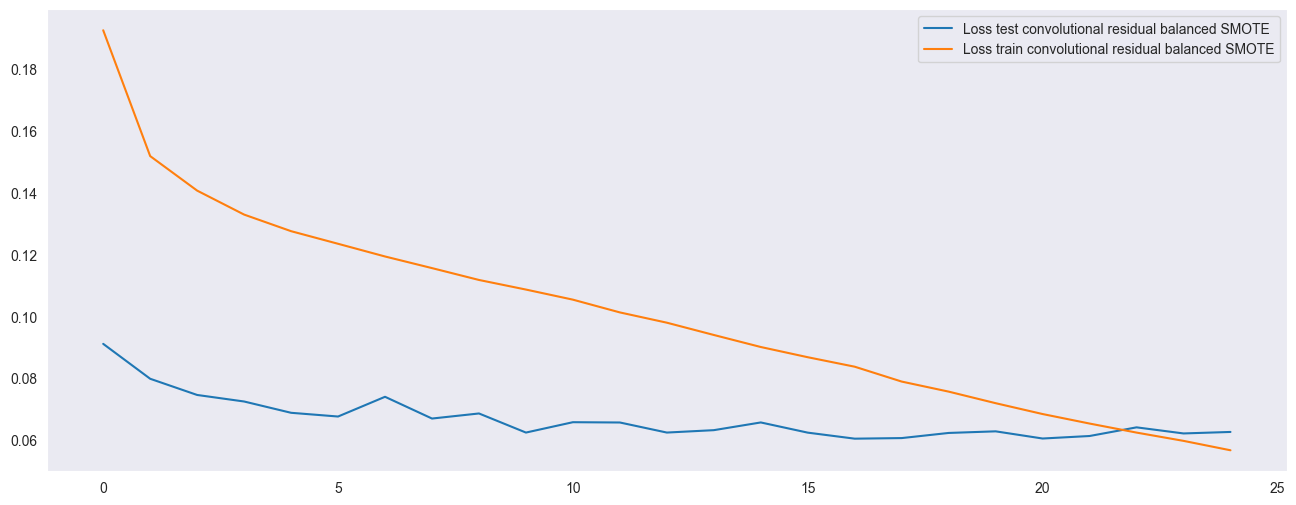

In [42]:
buffer.seek(0)
model_conv_residual_balanced_MLSMOTE = torch.load(buffer)

recurent_res_residual_balanced_MLSMOT = train_model(model_conv_residual_balanced_MLSMOTE, 0.001, Train_balanced_MLSMOTE_conv, Test_conv, 25, 0.5, 'convolutional residual balanced SMOTE', 
                  [accuracy_score, precision_score, f1_score], verbose=1)

In [44]:
del buffer